<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Before-you-start" data-toc-modified-id="Before-you-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Before you start</a></span></li><li><span><a href="#Authentication-setup" data-toc-modified-id="Authentication-setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Authentication setup</a></span></li><li><span><a href="#Hands-off-workflow" data-toc-modified-id="Hands-off-workflow-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hands-off workflow</a></span></li></ul></div>

# Analysis Ready Data (ARD) workflow for MODIS Aqua L2P SST collection

This notebook demonstrates how to created a gridded "Data Cube", essentialy an ARD, from native Level 2P sea surface temperature (SST) data from the MODIS Aqua (https://doi.org/10.5067/GHMDA-2PJ19) collection or dataset.  It can also be applied to Terra L2P SST and other similar L2 satellite collections.


## Before you start

Before you beginning this tutorial, make sure you have an Earthdata account: [https://urs.earthdata.nasa.gov](https://urs.earthdata.nasa.gov) for the operations envionrment (most common) or [https://uat.urs.earthdata.nasa.gov](https://uat.urs.earthdata.nasa.gov) for the UAT environment.

Accounts are free to create and take just a moment to set up.

## Authentication setup

We need some boilerplate up front to log in to Earthdata Login.  The function below will allow Python
scripts to log into any Earthdata Login application programmatically.  To avoid being prompted for
credentials every time you run and also allow clients such as curl to log in, you can add the following
to a `.netrc` (`_netrc` on Windows) file in your home directory:

```
machine uat.urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating
"netrc access too permissive."

`$ chmod 0600 ~/.netrc` 

*You'll need to authenticate using the netrc method when running from command line with [`papermill`](https://papermill.readthedocs.io/en/latest/). You can log in manually by executing the cell below when running in the notebook client in your browser.*

In [30]:
from urllib import request, parse
from http.cookiejar import CookieJar
import getpass
import netrc
import requests
import urllib


def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.

    Valid endpoints include:
        uat.urs.earthdata.nasa.gov - Earthdata Login UAT (Harmony's current default)
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

In [31]:
setup_earthdata_login_auth('uat.urs.earthdata.nasa.gov')
#setup_earthdata_login_auth('uat.earthdata.nasa.gov')

# ARD workflow

The idea of this workflow is to:
1) Discover MODIS granules within a region of interest (ROI)

2) Make spatial subsets of the dicovered granules

3) Remap those subsets to a common grid

4) Aggregate the maps to a "Data Cube": a co-registed set of images aggregated into a single file the cover the ROI

This is done using a combination NASA earthdata search and harmony services, and the python modules for the GDAL image transformation software, and the NCO toolkit. 

The first code block sets the input datasets, and time and space bounds 

In [32]:
# GHRSST MODIS Aqua L2P SST v2019.0 collection concept-id (UAT)
ccid = "C1234724470-POCLOUD"

# GHRSST MODIS Aqua L2P SST v2019.0 collection concept-id (CMR)
#ccid = "C1940473819-POCLOUD"

# GHRSST MODIS Terra L2P SST v2019.0 collection concept-id
#ccid = "C1234724471-POCLOUD"

# set the time  bounds  for search
start_time = '2020-07-01T00:01:15Z'
stop_time = '2020-07-30T00:01:15Z'
temporal_coverage = start_time + ',' + stop_time
print(temporal_coverage)

# set the space bounds
# mid Atlantic region
#west = -35. ; south = -5. ; east = -25. ; north = 5.

# Hawaiian Is.
west = -163 ; south = 15 ; east = -153 ; north = 25

# Southern California Bight
#west = -118 ; south = 32.5 ; east = -117 ; north = 33.5

spatial_coverage =  str(west) + ',' + str(south) + ',' + str(east) + ',' + str(north)
print(spatial_coverage)

# the local download directory
download_dir = "/Users/earmstro/Downloads/modis"


2020-07-01T00:01:15Z,2020-07-30T00:01:15Z
-163,15,-153,25


Kewyord parameters for the spatial and temporal granule CMR Harmony search

In [33]:
params = {
    'scroll': "true",
    'page_size': 2000,
    'sort_key': "-start_date",
    'collection_concept_id': ccid, 
    'temporal': temporal_coverage,
    'bounding_box': spatial_coverage
}

params

{'scroll': 'true',
 'page_size': 2000,
 'sort_key': '-start_date',
 'collection_concept_id': 'C1234724470-POCLOUD',
 'temporal': '2020-07-01T00:01:15Z,2020-07-30T00:01:15Z',
 'bounding_box': '-163,15,-153,25'}

Encode query parameters and create the complete search url:

In [34]:
from os import makedirs
from os.path import isdir, basename
from urllib.parse import urlencode
from urllib.request import urlopen, urlretrieve
from datetime import datetime, timedelta
from json import dumps, loads

cmr = "cmr.uat.earthdata.nasa.gov"
#cmr = "cmr.earthdata.nasa.gov"

query = urlencode(params)
url = f"https://{cmr}/search/granules.umm_json?{query}"
print(url)

https://cmr.uat.earthdata.nasa.gov/search/granules.umm_json?scroll=true&page_size=2000&sort_key=-start_date&collection_concept_id=C1234724470-POCLOUD&temporal=2020-07-01T00%3A01%3A15Z%2C2020-07-30T00%3A01%3A15Z&bounding_box=-163%2C15%2C-153%2C25


Print number of granules found in search

In [6]:
with urlopen(url) as f:
    results = loads(f.read().decode())

print(f"{results['hits']}  granules found in search for collection (dataset): {ccid} ")

143  granules found in search for collection (dataset): C1234724470-POCLOUD 


Neatly print the first granule record (if one was returned).  "concept-id" is the file (granule) reference we will use as input to Harmony subsetting service:

In [7]:
if len(results['items'])>0:
    print(dumps(results['items'][0], indent=2))

{
  "meta": {
    "concept-type": "granule",
    "concept-id": "G1236651714-POCLOUD",
    "revision-id": 2,
    "native-id": "20200729232501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0",
    "provider-id": "POCLOUD",
    "format": "application/vnd.nasa.cmr.umm+json",
    "revision-date": "2020-08-22T01:47:19.975Z"
  },
  "umm": {
    "TemporalExtent": {
      "RangeDateTime": {
        "EndingDateTime": "2020-07-29T23:30:00.000Z",
        "BeginningDateTime": "2020-07-29T23:25:01.000Z"
      }
    },
    "MetadataSpecification": {
      "URL": "https://cdn.earthdata.nasa.gov/umm/granule/v1.6.1",
      "Name": "UMM-G",
      "Version": "1.6.1"
    },
    "GranuleUR": "20200729232501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0",
    "ProviderDates": [
      {
        "Type": "Insert",
        "Date": "2020-08-22T01:46:32.695Z"
      },
      {
        "Type": "Update",
        "Date": "2020-08-22T01:46:32.710Z"
      }
    ],
    "SpatialExtent": {
      "HorizontalSpatialDomain": {


Find the concept-id for each file.  This is the key input for the harmony subsetting API and operation.

In [8]:
# Dump the granule concept Ids
file_ids = [r['meta']['concept-id'] for r in results['items']]
file_ids



['G1236651714-POCLOUD',
 'G1236651272-POCLOUD',
 'G1236645066-POCLOUD',
 'G1236645064-POCLOUD',
 'G1236629371-POCLOUD',
 'G1236629322-POCLOUD',
 'G1236629835-POCLOUD',
 'G1236619254-POCLOUD',
 'G1236619246-POCLOUD',
 'G1236619216-POCLOUD',
 'G1236619214-POCLOUD',
 'G1236616732-POCLOUD',
 'G1236616716-POCLOUD',
 'G1236610969-POCLOUD',
 'G1236608753-POCLOUD',
 'G1236599265-POCLOUD',
 'G1236597277-POCLOUD',
 'G1236586102-POCLOUD',
 'G1236586106-POCLOUD',
 'G1236574889-POCLOUD',
 'G1236568868-POCLOUD',
 'G1236548517-POCLOUD',
 'G1236548522-POCLOUD',
 'G1236545385-POCLOUD',
 'G1236524266-POCLOUD',
 'G1236524296-POCLOUD',
 'G1236524937-POCLOUD',
 'G1236518738-POCLOUD',
 'G1236510062-POCLOUD',
 'G1236506894-POCLOUD',
 'G1236506897-POCLOUD',
 'G1236504919-POCLOUD',
 'G1236504881-POCLOUD',
 'G1236490948-POCLOUD',
 'G1236490073-POCLOUD',
 'G1236478030-POCLOUD',
 'G1236478027-POCLOUD',
 'G1236475862-POCLOUD',
 'G1236469571-POCLOUD',
 'G1236469569-POCLOUD',
 'G1236457567-POCLOUD',
 'G1236457898-PO

Dump the corresponding filenames and location URLs for each concept id for inspection and well being

In [9]:
# Dump the URLs (containing orignal filenames) for the corresponding files ids

file_urls = [[u['URL'] for u in r['umm']['RelatedUrls'] if u['Type']=="GET DATA"][0] for r in results['items']]
file_urls 

['https://archive.podaac.uat.earthdata.nasa.gov/podaac-uat-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20200729232501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc',
 'https://archive.podaac.uat.earthdata.nasa.gov/podaac-uat-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20200729232001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc',
 'https://archive.podaac.uat.earthdata.nasa.gov/podaac-uat-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20200729123001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc',
 'https://archive.podaac.uat.earthdata.nasa.gov/podaac-uat-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20200729122501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc',
 'https://archive.podaac.uat.earthdata.nasa.gov/podaac-uat-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20200729002000-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc',
 'https://archive.podaac.uat.earthdata.nasa.gov/podaac-uat-cumulus-protected/MODIS_A-JPL-L2P-v2019.0/20200729001500-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc'

**Perform the subsetting operation using the Earthdata Harmony service**

In [10]:
import shutil

# Harmony root
harmony_root = 'https://harmony.uat.earthdata.nasa.gov'

# Projection information 
# Geographic lat/lon
#proj_string = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'
#l2proj_encode = parse.quote(proj_string)
#print(proj_string)
#print(l2proj_encode)

# Loop over the file (granule) ids
for i in range(len(file_urls)):
   try:  
        harmonyConfig = {
            'collection_id': ccid,     
            'ogc-api-coverages_version': '1.0.0',
            'variable': 'all',
            'granuleId': file_ids[i],
            'lat': '(' + str(south) + ":" + str(north) + ')',
            'lon': '(' + str(west) + ":" + str(east) + ')',        
            #'subsettingCrs': l2proj_encode,
            #'outputCrs': l2proj_encode,
            #'interpolation': 'near',
            #'width': 1000,
            #'height': 1000
        }
         
        # reproject granule    
        #harmony_url = harmony_root + '/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?granuleId={granuleId}&interpolation={interpolation}&outputCrs={outputCrs}&height={height}&width={width}'.format(**harmonyConfig)
        
        # subset granule
        harmony_url = harmony_root + '/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?granuleId={granuleId}&subset=lat{lat}&subset=lon{lon}'.format(**harmonyConfig)
        print('Harmony URL', harmony_url)
        
        # store output in a defined directory with a meaninful filename based on orginal name
        out_file = download_dir + 'subset_' + basename(file_urls[i])
       
        
        # -- execute the request --
        with request.urlopen(harmony_url) as response, open(out_file, 'wb') as output:
           shutil.copyfileobj(response, output) 
        
        
   except urllib.error.HTTPError as e:
        print(f"    [{datetime.now()}] FAILURE: {f}\n\n{e}\n{e.read()}\n")
        raise e                     
   except Exception as e:
        print(f"    [{datetime.now()}] FAILURE: {f}\n\n{e}\n")
        raise e
   else:
        print(f"    [{datetime.now()}]  SUCCESS for: {out_file}")
        print('    Content Size (bytes):', response.headers['Content-length'])
        print()

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleId=G1236651714-POCLOUD&subset=lat(15:25)&subset=lon(-163:-153)
    [2021-02-23 19:36:03.223476]  SUCCESS for: /Users/earmstro/Downloads/subset_20200729232501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
    Content Size (bytes): 2936112

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleId=G1236651272-POCLOUD&subset=lat(15:25)&subset=lon(-163:-153)
    [2021-02-23 19:36:32.954854]  SUCCESS for: /Users/earmstro/Downloads/subset_20200729232001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
    Content Size (bytes): 7814279

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleId=G1236645066-POCLOUD&subset=lat(15:25)&subset=lon(-163:-153)
    [2021-02-23 19:37:08.119735]  SUCCESS for

    [2021-02-23 19:47:10.327426]  SUCCESS for: /Users/earmstro/Downloads/subset_20200725125001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
    Content Size (bytes): 8718414

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleId=G1236545385-POCLOUD&subset=lat(15:25)&subset=lon(-163:-153)
    [2021-02-23 19:47:36.768752]  SUCCESS for: /Users/earmstro/Downloads/subset_20200725111500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
    Content Size (bytes): 584124

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleId=G1236524266-POCLOUD&subset=lat(15:25)&subset=lon(-163:-153)
    [2021-02-23 19:48:04.144194]  SUCCESS for: /Users/earmstro/Downloads/subset_20200725004501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
    Content Size (bytes): 290967

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCL

    [2021-02-23 19:57:37.893813]  SUCCESS for: /Users/earmstro/Downloads/subset_20200721131501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
    Content Size (bytes): 1932807

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleId=G1236457676-POCLOUD&subset=lat(15:25)&subset=lon(-163:-153)
    [2021-02-23 19:58:07.742345]  SUCCESS for: /Users/earmstro/Downloads/subset_20200721114001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
    Content Size (bytes): 6894419

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleId=G1236457769-POCLOUD&subset=lat(15:25)&subset=lon(-163:-153)
    [2021-02-23 19:58:39.932371]  SUCCESS for: /Users/earmstro/Downloads/subset_20200721113501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
    Content Size (bytes): 1248232

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-PO

    [2021-02-23 20:08:19.988795]  SUCCESS for: /Users/earmstro/Downloads/subset_20200716125501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
    Content Size (bytes): 3025708

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleId=G1236387214-POCLOUD&subset=lat(15:25)&subset=lon(-163:-153)
    [2021-02-23 20:08:48.532219]  SUCCESS for: /Users/earmstro/Downloads/subset_20200716112001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
    Content Size (bytes): 2010370

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleId=G1236387025-POCLOUD&subset=lat(15:25)&subset=lon(-163:-153)
    [2021-02-23 20:09:15.151615]  SUCCESS for: /Users/earmstro/Downloads/subset_20200716005000-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
    Content Size (bytes): 1078480

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-PO

    [2021-02-23 20:18:58.587311]  SUCCESS for: /Users/earmstro/Downloads/subset_20200711233501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
    Content Size (bytes): 22352006

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleId=G1236216369-POCLOUD&subset=lat(15:25)&subset=lon(-163:-153)
    [2021-02-23 20:19:29.087687]  SUCCESS for: /Users/earmstro/Downloads/subset_20200711233001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
    Content Size (bytes): 388881

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleId=G1236195062-POCLOUD&subset=lat(15:25)&subset=lon(-163:-153)
    [2021-02-23 20:19:59.954725]  SUCCESS for: /Users/earmstro/Downloads/subset_20200711124001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
    Content Size (bytes): 20499300

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-P

    [2021-02-23 20:29:49.847517]  SUCCESS for: /Users/earmstro/Downloads/subset_20200707130500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
    Content Size (bytes): 2277444

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleId=G1236056396-POCLOUD&subset=lat(15:25)&subset=lon(-163:-153)
    [2021-02-23 20:30:17.887689]  SUCCESS for: /Users/earmstro/Downloads/subset_20200707112500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
    Content Size (bytes): 3633830

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleId=G1236031673-POCLOUD&subset=lat(15:25)&subset=lon(-163:-153)
    [2021-02-23 20:30:45.530166]  SUCCESS for: /Users/earmstro/Downloads/subset_20200707005501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
    Content Size (bytes): 1226106

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-PO

    [2021-02-23 20:40:16.498457]  SUCCESS for: /Users/earmstro/Downloads/subset_20200703132501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
    Content Size (bytes): 77598

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleId=G1235884590-POCLOUD&subset=lat(15:25)&subset=lon(-163:-153)
    [2021-02-23 20:40:46.886989]  SUCCESS for: /Users/earmstro/Downloads/subset_20200703115001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
    Content Size (bytes): 16719774

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleId=G1235856554-POCLOUD&subset=lat(15:25)&subset=lon(-163:-153)
    [2021-02-23 20:41:17.330931]  SUCCESS for: /Users/earmstro/Downloads/subset_20200702234001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
    Content Size (bytes): 26259321

Harmony URL https://harmony.uat.earthdata.nasa.gov/C1234724470-PO

**Perform resampling/reprojection on subsets using the GDAL module and gdal.Warp().** GDAL will only work on one variable ("layer") at a time and also strip out important CF metadata and coordinate variables. Therefore we will use **NCO tricks** to correct these artifacts here and in the next steps. Use the 'pynco' module for NCO python bindings.

In [11]:
from osgeo import gdal, gdalconst
from nco import Nco

nco = Nco()

# keyword args for gdal.Warp()
kwargs = {'format': 'netCDF', 'copyMetadata': True, 
           'outputBounds': [west, south, east, north], 
           'xRes': 0.01,
           'yRes' : 0.01,
           'dstSRS':'+proj=longlat +datum=WGS84 +no_defs',
         }
print(kwargs)

nc_vars = ['sea_surface_temperature', 'quality_level']

# Loop through subsetted files (use file_urls as the loop list) and warp into defined region from kwargs{}

for i in range(len(file_urls)):
    for j in range(len(nc_vars)): 
      variable = nc_vars[j]
     
      # input filename
      src_filename = download_dir + 'subset_' + basename(file_urls[i]) 
      print("source filename: ", src_filename)
        
      # load the netCDF 'layer' like sea_surface_temperature (variable)
      nc_file = 'NETCDF:' + src_filename + ':' + variable
      print(nc_file)
    
      # try/catch for GDAL steps. Dont work on empty netCDF file from subsetting operation  
      try:
        src = gdal.Open(nc_file, gdalconst.GA_ReadOnly)

        #subDatasets = src.GetSubDatasets()
        #print('subsdatatsets', subDatasets)

        # set output filename
        out_filename = download_dir + 'subset_reproject-' + variable +  '-' + basename(file_urls[i]) 
        ds = gdal.Warp(out_filename, src, **kwargs)
        print("")

        del ds
        del src     
        
        # add time dimenson to 'Band1' using NCO
        nco.ncecat(input=out_filename, output='tmp.nc', options=['-v Band1 -u time'])
        nco.ncks(input='tmp.nc', output=out_filename, options=['-v Band1'])

        # use NCO to copy (append with -A ) the time variable to the output and make it a record dimension
        nco.ncks(input=src_filename, output=out_filename, options=['-v time -A --mk_rec_dmn time'])

      except Exception as e:
        print(f"    [{datetime.now()}] FAILURE: \n")
        #raise e   
      else:
        print(f"    [{datetime.now()}]  SUCCESS for: {out_filename}")
        print()


{'format': 'netCDF', 'copyMetadata': True, 'outputBounds': [-163, 15, -153, 25], 'xRes': 0.01, 'yRes': 0.01, 'dstSRS': '+proj=longlat +datum=WGS84 +no_defs'}
source filename:  /Users/earmstro/Downloads/subset_20200729232501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200729232501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc:sea_surface_temperature

    [2021-02-23 20:52:17.036546]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200729232501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200729232501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200729232501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc:quality_level

    [2021-02-23 20:52:17.435469]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200729232501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc

source filename:


    [2021-02-23 20:52:27.565262]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200727233501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200727233501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200727233501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc:quality_level

    [2021-02-23 20:52:28.275107]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200727233501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200727233001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200727233001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc:sea_surface_temperature

    [2021-02-23 20:52:28.622680]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200727233001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.

    [2021-02-23 20:52:39.459650]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200725125500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200725125001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200725125001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:sea_surface_temperature

    [2021-02-23 20:52:40.179956]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200725125001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200725125001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200725125001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:quality_level

    [2021-02-23 20:52:40.697644]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200725125001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

sourc


    [2021-02-23 20:52:49.400034]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200723235500-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200723130500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200723130500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:sea_surface_temperature

    [2021-02-23 20:52:50.087508]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200723130500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200723130500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200723130500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:quality_level

    [2021-02-23 20:52:50.597177]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200723130500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

sour

    [2021-02-23 20:53:00.116076]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200721132001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200721131501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200721131501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:sea_surface_temperature

    [2021-02-23 20:53:00.705701]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200721131501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200721131501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200721131501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:quality_level

    [2021-02-23 20:53:01.182753]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200721131501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

sourc


    [2021-02-23 20:53:10.232926]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200719224501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200719224501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200719224501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc:quality_level

    [2021-02-23 20:53:10.472837]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200719224501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200719132501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200719132501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:sea_surface_temperature

    [2021-02-23 20:53:10.702093]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200719132501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.


    [2021-02-23 20:53:19.822705]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200716130001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200716130001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200716130001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:quality_level

    [2021-02-23 20:53:20.237141]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200716130001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200716125501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200716125501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:sea_surface_temperature

    [2021-02-23 20:53:20.681260]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200716125501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.


    [2021-02-23 20:53:29.698122]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200714131001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200714131001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200714131001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:quality_level

    [2021-02-23 20:53:30.166671]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200714131001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200714113500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200714113500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:sea_surface_temperature

    [2021-02-23 20:53:30.578540]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200714113500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.


    [2021-02-23 20:53:37.210722]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200712132000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200712132000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200712132000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:quality_level

    [2021-02-23 20:53:37.578499]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200712132000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200711233501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200711233501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc:sea_surface_temperature

    [2021-02-23 20:53:38.670878]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200711233501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.


    [2021-02-23 20:53:48.630352]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200709234501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200709125500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200709125500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:sea_surface_temperature

    [2021-02-23 20:53:49.029574]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200709125500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200709125500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200709125500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:quality_level

    [2021-02-23 20:53:49.361684]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200709125500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

sour


    [2021-02-23 20:53:57.880345]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200708000000-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200707235500-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200707235500-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc:sea_surface_temperature

    [2021-02-23 20:53:58.329695]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200707235500-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200707235500-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200707235500-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc:quality_level

    [2021-02-23 20:53:58.684833]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200707235500-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc

sour


    [2021-02-23 20:54:07.920913]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200705132001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200705132001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200705132001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:quality_level

    [2021-02-23 20:54:08.168872]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200705132001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200705131501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200705131501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:sea_surface_temperature

    [2021-02-23 20:54:08.687999]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200705131501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.


    [2021-02-23 20:54:17.558804]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200704002001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200703224501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200703224501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc:sea_surface_temperature

    [2021-02-23 20:54:17.860789]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200703224501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200703224501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200703224501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc:quality_level

    [2021-02-23 20:54:18.097932]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200703224501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc

sour


    [2021-02-23 20:54:28.229734]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200701120500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200701120000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200701120000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:sea_surface_temperature

    [2021-02-23 20:54:28.857768]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-sea_surface_temperature-20200701120000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc

source filename:  /Users/earmstro/Downloads/subset_20200701120000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
NETCDF:/Users/earmstro/Downloads/subset_20200701120000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc:quality_level

    [2021-02-23 20:54:29.266966]  SUCCESS for: /Users/earmstro/Downloads/subset_reproject-quality_level-20200701120000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc



**Add variable level CF metadata information that GDAL stripped out using NCO commands.** Use the 'pynco' module for NCO python bindings.

In [12]:
import glob, os
#import shutil
from nco import Nco

nco = Nco()

sstConfig = {
            'scale_factor': 0.005,     
            'add_offset': 273.15,
            'valid_max': 10000,
            'valid_min': -1000,
            'long_name': 'sea surface temperature',
            'standard_name': 'sea_surface_skin_temperature',
            'coverage_content_type': 'physicalMeasurement'
            }

qualityConfig = {
            'valid_max': 0,
            'valid_min': 5, 
            'flag_values': '0b, 1b, 2b, 3b, 4b, 5b',
            'flag_meanings': 'no_data bad_data worst_quality low_quality acceptable_quality best_quality',
            'long_name': 'quality level of SST pixel',
            'coverage_content_type': 'qualityInformation'
            }
 
# Atted() method appears broken    
#sstOpts = [
#             c.Atted(mode="o", attName="scale_factor", varName=variable, Value=0.005, sType='f'), 
#             c.Atted(mode="o", attName="add_offsdt", varName=variable, Value=273.15, sType='f'), 
#             c.Atted(mode="o", attName="valid_min", varName=variable, Value=-1000, sType='s'), 
#]
            
nc_vars = ['sea_surface_temperature', 'quality_level']
os.chdir(download_dir)

for i in range(len(nc_vars)): 
    variable = nc_vars[i]
    reg_ex = "subset*" + variable + "*"
    for file in glob.glob(reg_ex):
        if variable == 'sea_surface_temperature':
          print(" -> Updating "+ file)
          nco.ncrename(input=file, output=file, options=['-v .Band1,sea_surface_temperature'])
        
          #sstOpts = {'mode':'o', 'attName':'scale_factor', 'varName':variable, 'Value':0.005, 'sType':'f'}
          #nco.ncatted(input=file, output=file, options=sstOpts)

          # update the SST variable attributes
          nco.ncatted(input=file, output=file, options=['-a scale_factor,'+ variable + ',o,f,{scale_factor}'.format(**sstConfig)])
          nco.ncatted(input=file, output=file, options=['-a add_offset,'+ variable + ',o,f,{add_offset}'.format(**sstConfig)])
          nco.ncatted(input=file, output=file, options=['-a valid_min,'+ variable + ',o,s,{valid_min}'.format(**sstConfig)])
          nco.ncatted(input=file, output=file, options=['-a valid_max,'+ variable + ',o,s,{valid_max}'.format(**sstConfig)])
          nco.ncatted(input=file, output=file, options=['-a long_name,'+ variable + ',o,c,"{long_name}"'.format(**sstConfig)])
          nco.ncatted(input=file, output=file, options=['-a standard_name,'+ variable + ',o,c,{standard_name}'.format(**sstConfig)])
          nco.ncatted(input=file, output=file, options=['-a coverage_content_type,'+ variable + ',o,c,{coverage_content_type}'.format(**sstConfig)])
            
        elif variable == 'quality_level':
          print(" -> Updating "+ file)
        
          nco.ncrename(input=file, output=file, options=['-v .Band1,' + variable])

          # update the quality variable attributes
          nco.ncatted(input=file, output=file, options=['-a valid_min,'+ variable + ',o,s,{valid_min}'.format(**qualityConfig)])
          nco.ncatted(input=file, output=file, options=['-a valid_max,'+ variable + ',o,s,{valid_max}'.format(**qualityConfig)])
          nco.ncatted(input=file, output=file, options=['-a long_name,'+ variable + ',o,c,"{long_name}"'.format(**qualityConfig)])
          nco.ncatted(input=file, output=file, options=['-a flag_values,'+ variable + ',o,c,"{flag_values}"'.format(**qualityConfig)])
          nco.ncatted(input=file, output=file, options=['-a flag_meanings,'+ variable + ',o,c,"{flag_meanings}"'.format(**qualityConfig)])
          nco.ncatted(input=file, output=file, options=['-a coverage_content_type,'+ variable + ',o,c,{coverage_content_type}'.format(**qualityConfig)])
     
    
print( "-Done-\n")

 -> Updating subset_reproject-sea_surface_temperature-20200701120000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20200701120500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20200701225500-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20200701230000-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20200702003501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20200702124501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20200702234001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20200703115001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20

 -> Updating subset_reproject-sea_surface_temperature-20200719115001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20200719132501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20200719224501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20200720002001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20200720002501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20200720123000-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20200720123500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20200720232500-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-sea_surface_temperature-20

 -> Updating subset_reproject-quality_level-20200705131501-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200705132001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200706001001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200706122001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200706122500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200706231501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200707005001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200707005501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200707112500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reprojec

 -> Updating subset_reproject-quality_level-20200724230001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200724230501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200725004001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200725004501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200725111500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200725125001-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200725125500-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200725234501-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reproject-quality_level-20200725235000-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0.nc
 -> Updating subset_reprojec

**Create the MODIS SST Data Cube.** Copy variable(s) to SST target files and catenate all of them into a final output  netCDF file using NCO.

In [13]:
import glob, os
from nco import Nco

nco = Nco()
os.chdir(download_dir)


# Loop through the SST files and add variable quality_level to SST file (target)
reg_ex = "subset_reproject-sea_surface_temperature*"

print( "Copying quality_level variables to target sst files . . .")
for sst_file in glob.glob(reg_ex):    
    quality_file = sst_file.replace("sea_surface_temperature", "quality_level")  
    nco.ncks(input=quality_file, output=sst_file, options=['-v quality_level -A'])
    
    
# Create the data cube using NCO ncrcat command
print(". . . -Done- \n\nCreating MODIS SST data cube . . . ")
nco.ncrcat(input=glob.glob(reg_ex), output='MODIS_SST.data-cube.nc')
print(". . . -Done- \n")



Copying quality_level variables to target sst files . . .
. . . -Done- 

Creating MODIS SST data cube . . . 
. . . -Done- 



Read the data with xarray and perform some plotting

<xarray.Dataset>
Dimensions:                  (lat: 10, lon: 10, time: 123)
Coordinates:
  * lat                      (lat) float64 20.0 20.02 20.02 ... 20.09 20.09
  * lon                      (lon) float64 -159.0 -159.0 ... -158.9 -158.9
  * time                     (time) datetime64[ns] 2020-07-01T12:00:00 ... 2020-07-30T13:10:01
Data variables:
    sea_surface_temperature  (time, lat, lon) float32 nan nan nan ... nan nan
    crs                      (time, lat, lon) object b'' b'' b'' ... b'' b'' b''
    quality_level            (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    Conventions:                CF-1.5
    GDAL:                       GDAL 3.1.4, released 2020/10/20
    history:                    Tue Feb 23 20:56:51 2021: /Users/earmstro/ana...
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    history_of_appended_files:  Tue Feb 23 20:56:41 2021: Appended file subse...


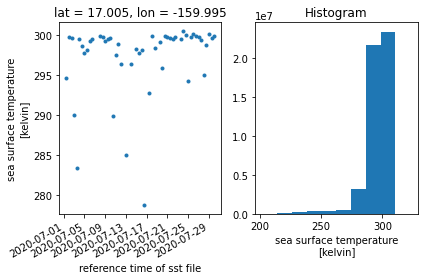

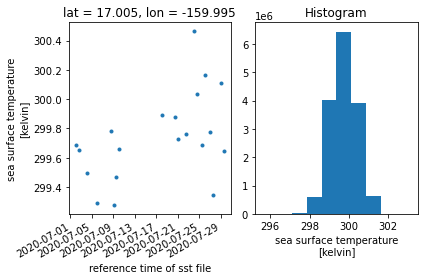

In [128]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

dataCube = download_dir + 'MODIS_SST.data-cube.nc'
xds = xr.open_dataset(dataCube)
#print(xds)

# create objects for subplots
fig, axes = plt.subplots(ncols=2)

# plot a time series at a specific location
xds.sea_surface_temperature.isel(lat = 200, lon = 300).plot(ax=axes[0], marker = '.', linestyle = 'None')

# a histogram of all points in region of interest
xds.sea_surface_temperature.plot(ax=axes[1])

plt.tight_layout()
plt.draw()

#a=xds.where(xds.quality_level <= 2 )
#print(a.quality_level[10:100])
#print(where(xds.quality_level >=4))


subset = xds.where((xds.lat>20) & (xds.lat<20.1) & (xds.lon>-159) & (xds.lon<-158.9), drop=True)
print(subset)

#subset.sea_surface_temperature.isel(lat=0,lon=0).plot()
#subset.sea_surface_temperature.isel(mean(lat),mean(lon)).plot()


#lon = xds.lon
#print(lon)
#sublon = lon.where(lon==-155)
#print(sublon)

#a = xds.where(xds.lon==-155)
#print(" a is \n", a)

#print()
#print(xds.where((xds.lon==-157.025) & (xds.lat==17.235), drop=True))

#xds.sea_surface_temperature.isel(where(xds.lon <= -155), where(xds.lat>22)).plot()

# Filter the dataset using quality information (quality_level value 4 and 5 are best data)
qc_dataset = xds.where((xds['sea_surface_temperature'] < 310) & (xds['quality_level'] >= 4))

# re plot the time series at a specific location and the regional histogram
fig, axes = plt.subplots(ncols=2)
qc_dataset.sea_surface_temperature.isel(lat = 200, lon = 300).plot(ax=axes[0], marker = '.', linestyle = 'None')
qc_dataset.sea_surface_temperature.plot(ax=axes[1])

plt.tight_layout()
plt.draw()






